#Прогнозирование цены биткоина

##Содержание

1.   Описание проекта
2.   Подготовка данных
3.   LinearRegression
4.   RandomForest
5.   CatBoost
6.   NaiveModel
7.   Prophet

## Описание проекта



Цель: спрогнозировать цену биткоина (Price) на последние семь дней.

Последние семь дней продублированные значения из таблицы за последнюю известную дату - 8 дней назад.

## Подготовка данных

Загружаем данные

In [1]:
from google.colab import files

uploaded = files.upload()

Saving Bitcoin_kaggle.csv to Bitcoin_kaggle.csv


In [2]:
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("Bitcoin_kaggle.csv",
                  delimiter=';',
                  parse_dates=True,
                  index_col='Date'
                  )

print(len(data))

data = data.sort_index()

data.tail(10)

547


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-05,"30,512.8","30,768.6","30,875.6","30,233.3",43.23K,-0.83%
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-08,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-09,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-10,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-11,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-12,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-13,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%


Проверяем наличие пропусков:

In [3]:
data.isnull().sum()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

Преобразуем столбец Price в нужный формат:

<Axes: xlabel='Date'>

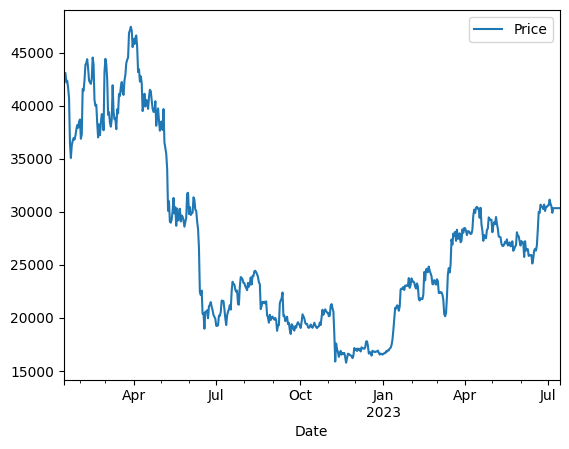

In [4]:
data['Price'] = data['Price'].apply(lambda x: float(x.replace(",","")))

data = data[['Price']]

data.plot()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2022-01-14 to 2023-07-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   547 non-null    float64
dtypes: float64(1)
memory usage: 8.5 KB


In [6]:
data.describe()

,Price
count,547.000000
mean,26968.041499
std,8279.352932
min,15776.200000
25%,20264.000000
50%,24631.400000
75%,30364.300000
max,47449.000000


Анализ датасета показал:



*   в датасете содержится 547 записей
*   за период 2022-01-14 - 2023-07-14
*   диапозон курса биткоина 15776.2 - 47449
*   средняя цена биткоина - 26968.041499



#LinearRegression

In [7]:
# функция для подсчета среднего значения цены по дням, неделям и т.д.
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Создадим функцию для добавления новых признаков в датасет и разбиения датасета на тренировочную и тестовую выборку:

In [8]:
target = "Price"

def preprocess_data(data, lag_start=7, lag_end=20, test_size=0.02):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
    # добавляем лаги в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data[target].shift(i)

    data["day"] = data.index.day

    # считаем средние
    data["day_average"] = list(map(code_mean(data[:test_index], "day", target).get, data.day))

    # удаляем лишние столбцы
    data.drop(["day"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target], axis=1)
    y_train = data.loc[:test_index][target]
    X_test = data.loc[test_index:].drop([target], axis=1)
    y_test = data.loc[test_index:][target]

    return X_train, X_test, y_train, y_test

Обучаем линейную регрессию

7


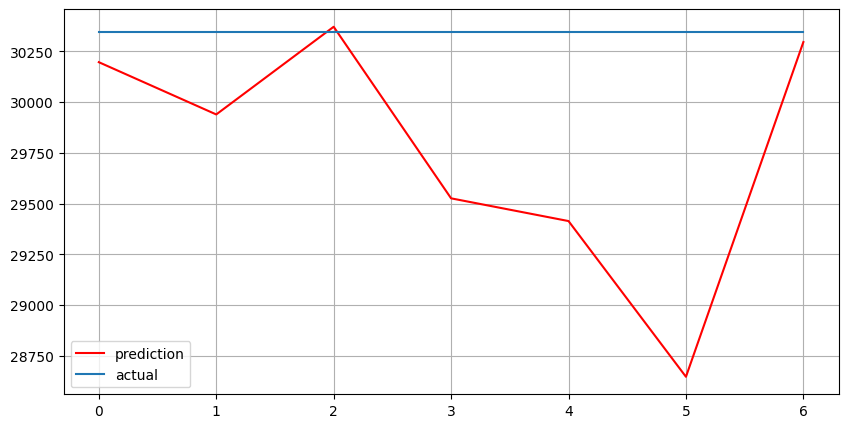

In [9]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = preprocess_data(data, test_size=0.035, lag_start=7, lag_end=14)

print(len(y_test))

lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")

Сохраним прогноз в файл и отправим на kaggle.

In [10]:
def save_prediction(column_data, column_target):
  X_test[column_data] = data.index[-7:]
  X_test[column_target] = preds

  X_test.set_index(column_data, inplace=True)

  X_test[[column_target]].to_csv("prediction_baseline.csv")

In [11]:
save_prediction('Date', 'Price')

In [12]:
X_test[['Price']]

,Price
Date,
2023-07-08,30196.939547
2023-07-09,29939.525845
2023-07-10,30371.300482
2023-07-11,29526.355905
2023-07-12,29414.429412
2023-07-13,28647.518808
2023-07-14,30296.037932


Получили Score: 894.05600

##RandomForest

Изменим немного нашу функцию для препроцессинга данных. Добавим в датасет столбец со средним значением за неделю.

In [13]:
target = "Price"

def preprocess_data_add_week(data, lag_start=7, lag_end=20, test_size=0.02):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data[target].shift(i)


    data["day"] = data.index.day
    data["week"] = data.index.week



    # считаем средние
    data["day_average"] = list(map(code_mean(data[:test_index], "day", target).get, data.day))
    data["week_average"] = list(map(code_mean(data[:test_index], "week", target).get, data.week))


    # удаляем лишние столбцы
    data.drop(["day", "week"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target], axis=1)
    y_train = data.loc[:test_index][target]
    X_test = data.loc[test_index:].drop([target], axis=1)
    y_test = data.loc[test_index:][target]

    return X_train, X_test, y_train, y_test

<ipython-input-13-060c21497d0d>:16: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week


7


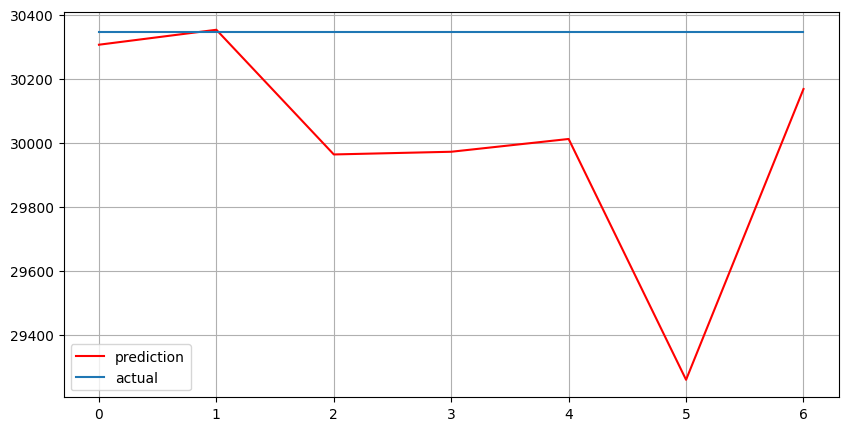

In [14]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = preprocess_data_add_week(data, test_size=0.035, lag_start=7, lag_end=14)

print(len(y_test))

rf = RandomForestRegressor(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")


In [15]:
save_prediction('Date', 'Price')

In [16]:
X_test[['Price']]

,Price
Date,
2023-07-08,30305.675230
2023-07-09,30352.330304
2023-07-10,29962.948987
2023-07-11,29971.364017
2023-07-12,30011.281310
2023-07-13,29259.203340
2023-07-14,30167.360787


Score: 784.19188

In [17]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


##CatBoost

<ipython-input-13-060c21497d0d>:16: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week


0:	learn: 7506.8657350	total: 48.3ms	remaining: 24.1s
1:	learn: 6894.2777654	total: 50.1ms	remaining: 12.5s
2:	learn: 6355.0498210	total: 51.4ms	remaining: 8.51s
3:	learn: 5855.2495109	total: 52.5ms	remaining: 6.51s
4:	learn: 5419.2244156	total: 54ms	remaining: 5.34s
5:	learn: 5031.9974195	total: 55.1ms	remaining: 4.54s
6:	learn: 4688.3647756	total: 58.4ms	remaining: 4.11s
7:	learn: 4392.9160183	total: 60.1ms	remaining: 3.69s
8:	learn: 4115.1094796	total: 62.9ms	remaining: 3.43s
9:	learn: 3862.9907415	total: 65.5ms	remaining: 3.21s
10:	learn: 3638.8634560	total: 67.1ms	remaining: 2.98s
11:	learn: 3440.4117982	total: 68ms	remaining: 2.76s
12:	learn: 3274.3991608	total: 68.8ms	remaining: 2.58s
13:	learn: 3130.8029884	total: 69.7ms	remaining: 2.42s
14:	learn: 2969.0660547	total: 70.7ms	remaining: 2.29s
15:	learn: 2842.0788516	total: 72ms	remaining: 2.18s
16:	learn: 2729.2131769	total: 73.6ms	remaining: 2.09s
17:	learn: 2631.0051252	total: 74.5ms	remaining: 1.99s
18:	learn: 2552.8623429	to

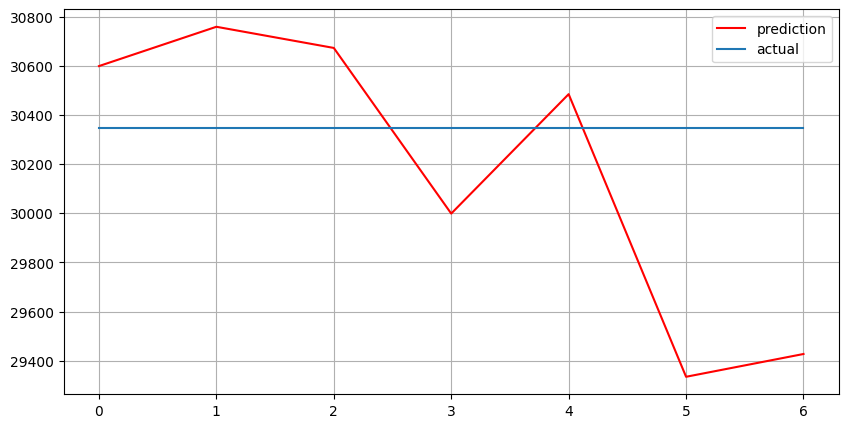

In [18]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=4)

X_train, X_test, y_train, y_test = preprocess_data_add_week(data, test_size=0.035, lag_start=7, lag_end=14)

cb.fit(X_train, y_train)
preds = cb.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")

In [19]:
save_prediction('Date', 'Price')

In [20]:
X_test[['Price']]

,Price
Date,
2023-07-08,30598.825190
2023-07-09,30758.750132
2023-07-10,30672.659689
2023-07-11,29998.770730
2023-07-12,30484.618298
2023-07-13,29334.803284
2023-07-14,29427.465522


Score: 841.10196

##ETNA

In [21]:
!pip install etna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.1/387.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

Загружаем заново наши данные.

In [22]:
data = pd.read_csv("Bitcoin_kaggle.csv",
                  delimiter=';',
                  parse_dates=True,
                  index_col='Date'
                  )

data = data.sort_index()

data['Price'] = data['Price'].apply(lambda x: float(x.replace(",","")))

data = data[['Price']]

data.tail(10)

,Price
Date,
2023-07-05,30512.8
2023-07-06,29913.1
2023-07-07,30346.4
2023-07-08,30346.4
2023-07-09,30346.4
2023-07-10,30346.4
2023-07-11,30346.4
2023-07-12,30346.4
2023-07-13,30346.4


Приведем данные к формату, с которым работает ETNA:

* колонка **timestamp** - время в формате datetime
* колонка **target** - целевая переменная (прогнозируемый ряд)
* колонка **segment** - **main** в случае, если целевая переменная - это один ряд

In [23]:
data = data.reset_index(names='Date')

data["timestamp"] = pd.to_datetime(data['Date'])
data["target"] = data["Price"]
data.drop(columns=["Date", "Price"], inplace=True)
data["segment"] = "main"

data.head()

,timestamp,target,segment
0,2022-01-14,43073.3,main
1,2022-01-15,43097.0,main
2,2022-01-16,43079.1,main
3,2022-01-17,42209.3,main
4,2022-01-18,42364.6,main


Приведем наши данные к специальному классу для работы с временными рядами - **TSDataset**.

In [24]:
from etna.datasets.tsdataset import TSDataset

data = TSDataset.to_dataset(data)
data.head()

/usr/local/lib/python3.10/dist-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:71: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install etna[auto]`")
/usr/loc

segment,main
feature,target
timestamp,
2022-01-14,43073.3
2022-01-15,43097.0
2022-01-16,43079.1
2022-01-17,42209.3
2022-01-18,42364.6


Нужно указать временной шаг (дни)

In [25]:
ts = TSDataset(data, freq="D")

In [26]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2022-01-14,2023-07-14,547,0,1,0,0,0,D


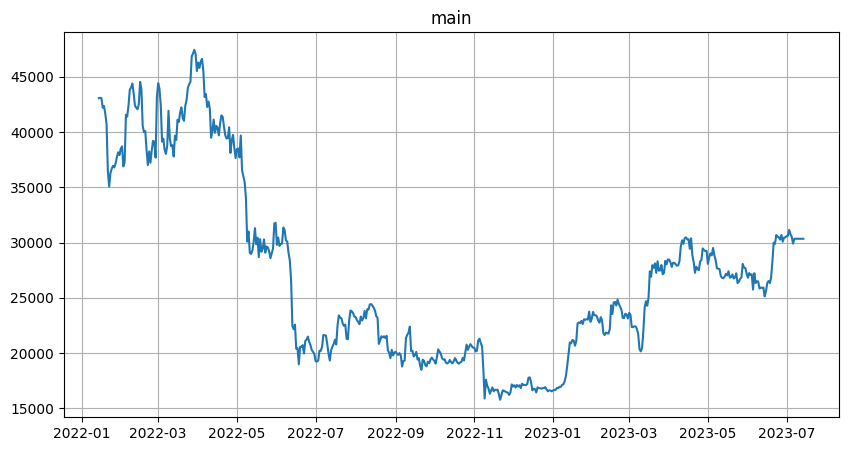

In [27]:
ts.plot()

In [28]:
train_ts, test_ts = ts.train_test_split(
    train_start="2022-01-14",
    train_end="2023-07-07",
    test_start="2023-07-08",
    test_end="2023-07-14",
)

##NaiveModel

In [29]:
HORIZON = 7 # горизонт прогнозирования

from etna.models import NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel

# обучаем модель
model1 = NaiveModel(lag=5)
model1.fit(train_ts)

# создаем forecast
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model1.context_size)
forecast_ts = model1.forecast(future_ts, prediction_size=HORIZON)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [30]:
forecast_ts

segment,main
feature,target
timestamp,
2023-07-08,31151.3
2023-07-09,30768.4
2023-07-10,30512.8
2023-07-11,29913.1
2023-07-12,30346.4
2023-07-13,31151.3
2023-07-14,30768.4


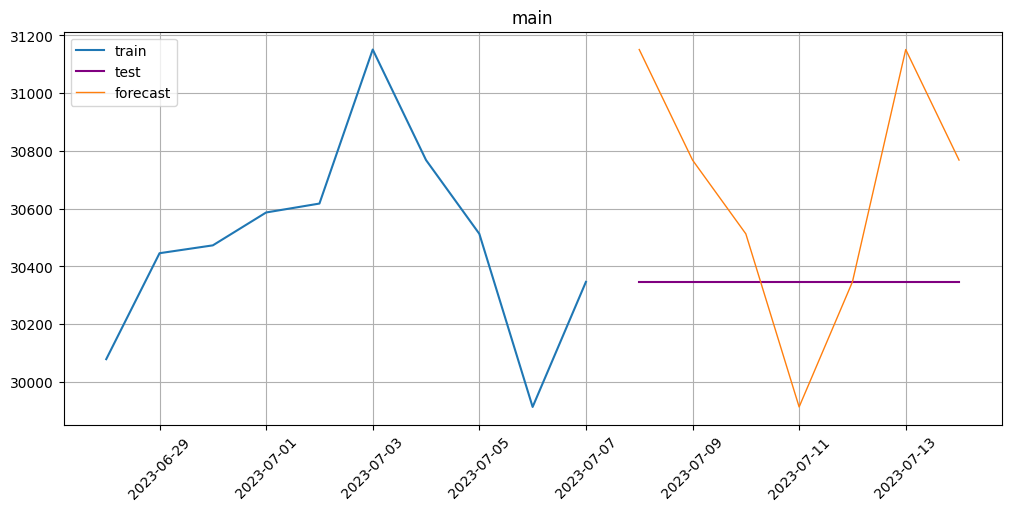

In [31]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

Возращаемся к пандавскому датафрейму.

In [32]:
data_ans = forecast_ts.to_pandas(True)

data_ans = data_ans[['timestamp', 'target']]

data_ans = data_ans.rename(columns={"timestamp": "Date", "target": "Price"})

data_ans.set_index('Date', inplace=True)

In [33]:
data_ans.to_csv("prediction_baseline.csv")

Score: 451.68571

##Prophet

In [34]:
from etna.models import ProphetModel

model2 = ProphetModel(growth = 'linear', yearly_seasonality = False, daily_seasonality = False)
model2.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model2.forecast(future_ts)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpr7wbj0xi/ao0al8s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr7wbj0xi/st6it0i7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42128', 'data', 'file=/tmp/tmpr7wbj0xi/ao0al8s8.json', 'init=/tmp/tmpr7wbj0xi/st6it0i7.json', 'output', 'file=/tmp/tmpr7wbj0xi/prophet_model0vos8ojb/prophet_model-20240211075653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [35]:
forecast_ts

segment,main
feature,target
timestamp,
2023-07-08,29540.763990
2023-07-09,29590.221466
2023-07-10,29645.087285
2023-07-11,29813.327616
2023-07-12,29810.358321
2023-07-13,29736.631472
2023-07-14,29758.673758


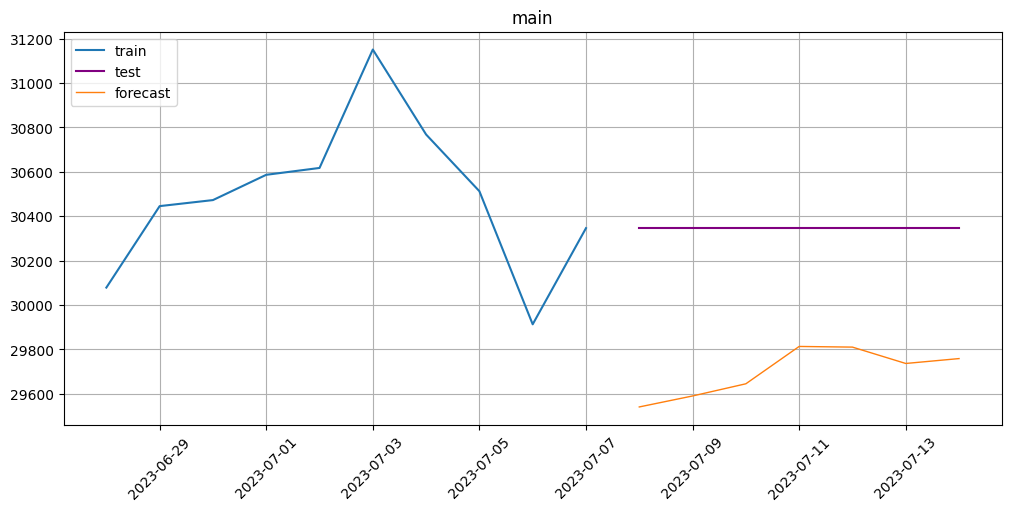

In [36]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [37]:
data_ans = forecast_ts.to_pandas(True)

data_ans = data_ans[['timestamp', 'target']]

data_ans = data_ans.rename(columns={"timestamp": "Date", "target": "Price"})

data_ans.set_index('Date', inplace=True)

In [38]:
data_ans.to_csv("prediction_baseline.csv")

Score: 965.06229